# Importing packages and load CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pypylon import pylon
from pypylon import genicam
# Importing busworks
import busworks
# import keras
# from keras import backend as k
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# import tensorflow as tf
# import pickle
from math import factorial
from copy import deepcopy
from tqdm import tqdm
import datetime
import time
import os
import sys

# Telling the notebook to make plots inline.
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)


# Initialization

In [2]:
n_pixl = 128
RepoDir = '/home/user1/Dropbox/Academic/WORK/Beam_auto_alignment'
ImagesFolder = RepoDir + '/Data/Actual_cavity_Fittest_points_per_gen_' + \
str(datetime.datetime.now()).replace(' ', '_').replace(':', '-')[:-10]
if not os.path.exists(ImagesFolder): os.mkdir(ImagesFolder)
# SaveModelFolder = '/home/user1/Dropbox/Academic/WORK/Beam_auto_alignment/Data/TrainedModels/'
# Model_Name = 'Trained_Model_2019-07-03_17-15'

# # Read the pre-trained CNN model
# cnn = keras.models.load_model(SaveModelFolder + Model_Name + '.h5')
# # load the encoder
# loaded_Encoder = pickle.load(open(SaveModelFolder + 'Encoder_of_' + Model_Name + '.npy', 'rb'))

#seed
np.random.seed(187)
# waist size in m
waist = 140e-6
# range of movement of the waist center at the waist location in the units of waist size
Range = 3.5
# max voltage o/p of DAC
V_DAC_max = 10.
HV_op_gain = 1.
# Max angular deviation of steering mirror (on each side)
phi_SM_max = 26.2e-3 #(rad) for newport mirrors. (Thorlabs : 73e-6 radians)
SM_drive_gain = 1.
SM_ip_voltage_range = [0, 10]
# Max displacement of cavity mirror (PZT) (on one side)
phi_CM_PZT_max = 2.8e-6 #(microns). starts from zero
CM_PZT_ip_voltage_range = [0, 200]
print('Cavity Mirror scanning range is [{}, {}] micron. The used range [{}, {}] micron should not go out.'\
      .format(0, phi_CM_PZT_max, 0, phi_CM_PZT_max*V_DAC_max*HV_op_gain/CM_PZT_ip_voltage_range[1]))
print('Steering Mirror scanning range is [-{0}, {0}] rad. The used range [-{1}, {1}] rad should not go out.'\
      .format(phi_SM_max, phi_SM_max*V_DAC_max*SM_drive_gain/SM_ip_voltage_range[1]))
# cumulative distance of waist from SM1 in m
d1 = 0.35+0.0884
# cumulative distance of waist from SM2 in m
d2 = 0.0884
scale_params = np.array([waist/d1, waist/d1, waist/d2, waist/d2, 1.064e-6])
PZT_scaling = np.array([V_DAC_max/phi_SM_max, V_DAC_max/phi_SM_max, \
                        V_DAC_max/phi_SM_max, V_DAC_max/phi_SM_max, V_DAC_max/phi_CM_PZT_max])
pop_per_gen = 500
num_generations = 25
num_params = len(scale_params)
num_parents_mating = pop_per_gen // 10 	# 10% of new population is parents
num_offsprings_per_pair = 2 * (pop_per_gen - num_parents_mating) // num_parents_mating + 1
# after each iteration, range shrinks by
shrink_factor = 2. / pop_per_gen ** 0.25  # make sure it is < 1.
# Defining the population size.
pop_size = (pop_per_gen,num_params) # The population will have sol_per_pop chromosome \
# where each chromosome has num_weights genes.
fitness = np.empty(pop_per_gen)

# camera exposure (check if right command!)
Exposure = 500

Cavity Mirror scanning range is [0, 2.8e-06] micron. The used range [0, 1.4e-07] micron should not go out.
Steering Mirror scanning range is [-0.0262, 0.0262] rad. The used range [-0.0262, 0.0262] rad should not go out.


## Start camera and DAC

In [3]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
print("Using Camera ", camera.GetDeviceInfo().GetModelName())
camera.Open()

# Sanity checks
print('Camera Auto Gain is :', camera.GainAuto())
if camera.GainAuto() == 'Off':
    print('Safe to go ahead with the code..')
else:
    print('***Warning: Camera Auto Gain is ON!***\nTurn it off using Pylon software.')
camera.ExposureTimeAbs = Exposure

# Start DAC
start_channel = 1
bus = busworks.BusWorks_DAC()
bus.start()
print("DAC on IP: ", bus.address)

Using Camera  acA720-290gm
Camera Auto Gain is : Off
Safe to go ahead with the code..
DAC on IP:  192.168.1.231


## Define Functions

In [4]:
def Capture_image(exposure):
    Dat = camera.GrabOne(exposure)
    img = Dat.Array
    return img

def sample_d(Rng, shape=pop_size):
    """
    Takes i/p range in umits of beam waist at the waist location.
    Outputs sets of deltas (in radians) to be fed to steering mirrors.
    O/P shape : pop_size
    """
    delta = np.random.uniform(low=-Rng, high=Rng, size=shape)
    # CM pzt does not take -ve values
    delta[:,shape[1]-1] = np.abs(delta[:,shape[1]-1])
    delta *= scale_params
    return delta

def scan_cavity(size):
    """
    Takes i/p range in umits of beam waist at the waist location.
    Outputs sets of deltas (in radians) to be fed to steering mirrors.
    O/P shape : pop_size
    """
    delta_z = np.random.uniform(low=0, high=1, size=size)
    delta_z *= scale_params[4]
    return delta_z

def Set_Voltage(Beam_status):
    ip_V = Beam_status * PZT_scaling
    # making sure that the DAC voltages remain in the required range
    # if (np.abs(ip_V) > V_DAC_max).sum() > 0:
        # print('DAC I/P voltage exceeded limit! Forcefully brought down.')
    ip_V[np.where(ip_V > V_DAC_max)] = V_DAC_max
    ip_V[np.where(ip_V < -V_DAC_max)] = -V_DAC_max
    try:
        # print(Beam_status)
        bus.set_voltages(ip_V, 1)
    except:
        print('Error!')


def Reward(Beam_status, return_img=False):
    Set_Voltage(Beam_status)
    # reward fn as total power in the image
    Img1 = Capture_image(Exposure)
    R_fn1 = Img1.sum()/n_pixl**2
    return R_fn1, Img1

def calc_pop_fitness(Current_beam_status, New_pop_deltas, fitness, only_offsprings=False):
    """
    Calculating the fitness value of each solution in the current population.
    Also returns the current beam location (after adding the steps taken so far)
    """
    # if only_offsprings:
    #     range_vals = range(num_parents_mating, pop_per_gen)
    # else:
    #     range_vals = range(pop_per_gen)
    range_vals = range(pop_per_gen)
    for ii in range_vals:
        # take the delta step
        Current_beam_status += New_pop_deltas[ii]
        # cumulatively subtracting each delta step from all deltas
        New_pop_deltas -= New_pop_deltas[ii]
        R_new, _ = Reward(Current_beam_status, return_img=False)
        fitness[ii] = R_new
    return Current_beam_status, New_pop_deltas, fitness

def select_mating_pool(pop, fitness, num_parents_mating, show_the_best=False, save_best=False):
    """
    Selecting the best candidates in the current generation as parents for 
    producing the offspring of the next generation.
    """
    parents = np.empty((num_parents_mating, num_params))
    isort = np.argsort(fitness)[::-1]
    parents_fitness = fitness[isort][:num_parents_mating]
    parents = pop[isort][:num_parents_mating,:]
    if show_the_best:
        t1 = time.time() - t0
        print('Time: {}, Fittest Parent: {}, Fitness: {}'.format(t1, parents[0], parents_fitness[0]))
        _, Img = Reward(parents[0], return_img=True)
        plt.imshow(Img[::-1], cmap=cm.binary_r)
        plt.colorbar()
        if save_best:
            if gen < 10:
                plt.savefig(ImagesFolder + '/Gen_0%d_time_%d_Power_%1.2f_alignments_%f_%f_%f_%f_endMirror_%f.png' \
                     %(gen, (t1), parents_fitness[0], parents[0][0], \
                       parents[0][1], parents[0][2], parents[0][3], parents[0][4]))
            else:
                plt.savefig(ImagesFolder + '/Gen_%d_time_%d_Power_%1.2f_alignments_%f_%f_%f_%f_endMirror_%f.png' \
                     %(gen, (t1), parents_fitness[0], parents[0][0], \
                       parents[0][1], parents[0][2], parents[0][3], parents[0][4]))
        plt.show()
    return parents, parents_fitness

def get_offsprings_Uniform(pairs, parents, offspring_size):
    """create offsprings using uniform crossover"""
    offsprings = np.empty(offspring_size)
    nn = 0
    for i in range(len(pairs)):
        for j in range(num_offsprings_per_pair):
            if nn == offspring_size[0] : break
            while True:
                # To make sure not all True/False
                i_select_genes = np.random.choice([True, False], num_params)
                if (i_select_genes.sum() != num_params) & (i_select_genes.sum() != 0): break
            offsprings[nn][i_select_genes] = parents[pairs[i][0]][i_select_genes]
            offsprings[nn][np.logical_not(i_select_genes)] = \
            parents[pairs[i][1]][np.logical_not(i_select_genes)]
            nn += 1
    return offsprings

def crossover(parents, offspring_size):
    # get all possible pairs
    pairs = []
    for p1 in range(num_parents_mating):
        for p2 in range(p1+1, num_parents_mating):
            pairs.append([p1,p2])
    pairs = np.array(pairs)
    # Give preference to combinations of top performing parents
    i_sort = np.argsort(pairs.sum(axis=1))
    pairs = pairs[i_sort]
    offsprings = get_offsprings_Uniform(pairs, parents, offspring_size)
    return offsprings

def mutation(Offspring_crossover, Rng):
    # Mutation changes a single gene in each offspring randomly.
    mutations = sample_d(Rng, shape=Offspring_crossover.shape)
    # The random value to be added to the gene.
    Offspring_crossover += mutations
    return Offspring_crossover

## Initial State

Initial condition: 627.363037109375


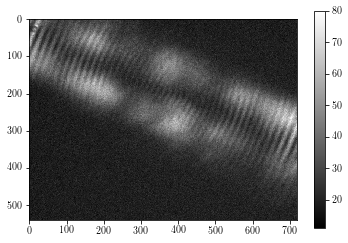

In [5]:
Img_initial = Capture_image(1000)
print('Initial condition: {}'.format(Img_initial.sum()/n_pixl**2))
plt.imshow(Img_initial[::-1], cmap=cm.binary_r)
plt.colorbar()
# Initial condition of beam
current_beam_status = np.zeros(num_params)

## Scanning the cavity first

In [6]:
# # Scan the cavity
# gen = 0
# t0 = time.time()

# new_pop_deltas_i = np.zeros(pop_size)
# new_pop_deltas_i[:,pop_size[1]-1] = scan_cavity(pop_size[0])
# current_beam_status, new_pop_deltas_i, fitness = calc_pop_fitness(current_beam_status, \
#         new_pop_deltas_i, fitness, only_offsprings=False)
# # Selecting the best parents in the population for mating.
# parents, parents_fitness = select_mating_pool(new_pop_deltas_i, fitness, \
#                                             num_parents_mating, show_the_best=True, save_best=False)

## Alignment loop



Range: 3.5 x waist


 Gen: 0 Range: 1.4803197688167897 x waist
Time: 33.782371520996094, Fittest Parent: [ 1.55029007e-03  8.11634052e-04  3.95827985e-03 -9.34981819e-04
  4.01724252e-07], Fitness: 1361.5145263671875


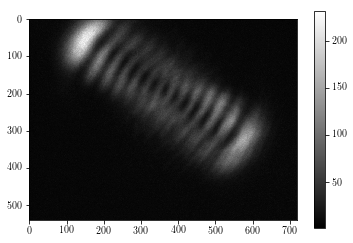



 Gen: 1 Range: 0.6260990336999411 x waist
Time: 67.84982466697693, Fittest Parent: [-4.77203671e-04 -1.78358103e-03  1.70670727e-03  7.29190444e-04
 -4.35562269e-07], Fitness: 1862.8784790039062


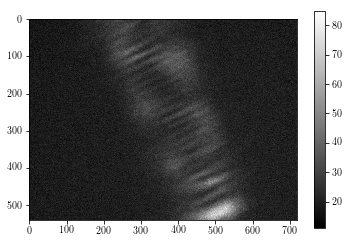



 Gen: 2 Range: 0.2648076505208892 x waist
Time: 101.88044118881226, Fittest Parent: [-2.96151055e-04  5.31009840e-04 -3.00937885e-03 -4.14407378e-03
  3.73059678e-06], Fitness: 1534.3544921875


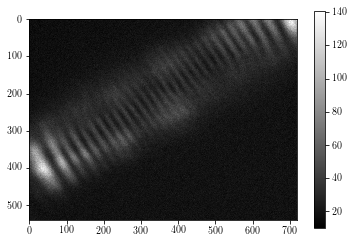



 Gen: 3 Range: 0.112 x waist
Time: 135.9473249912262, Fittest Parent: [ 1.09837182e-03 -5.79822712e-04  7.93937490e-03  6.64629219e-03
  2.28654333e-07], Fitness: 1597.744873046875


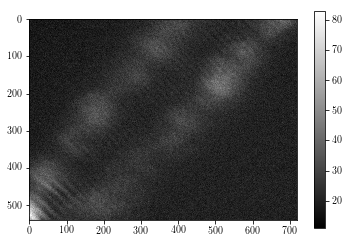



 Gen: 4 Range: 0.04737023260213727 x waist
Time: 169.97655320167542, Fittest Parent: [-9.10769530e-04 -7.68264028e-04 -7.17460896e-04  3.28613512e-04
 -2.63795628e-07], Fitness: 1484.3729858398438


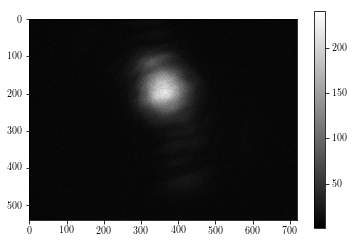



 Gen: 5 Range: 0.020035169078398113 x waist
Time: 203.98618030548096, Fittest Parent: [-1.77388951e-04  1.16273602e-03 -9.83569058e-05 -1.19018958e-04
  2.25318284e-08], Fitness: 1588.4042358398438


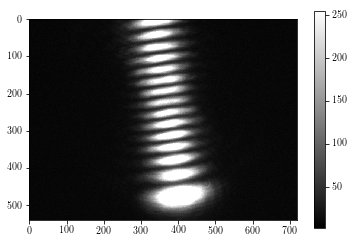



 Gen: 6 Range: 0.008473844816668455 x waist
Time: 238.09921407699585, Fittest Parent: [-1.35430264e-05 -2.49607310e-05 -4.43330228e-04 -2.70159936e-03
 -3.51198140e-07], Fitness: 1958.554931640625


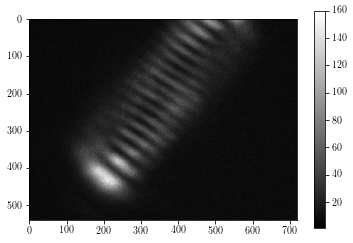



 Gen: 7 Range: 0.0035839999999999995 x waist
Time: 272.19236063957214, Fittest Parent: [-8.80613292e-06 -2.07596964e-05 -7.10162143e-05  4.49081391e-06
 -3.38062494e-06], Fitness: 1968.504638671875


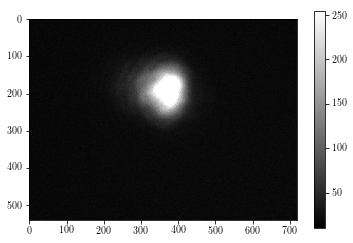



 Gen: 8 Range: 0.0015158474432683925 x waist
Time: 306.25288248062134, Fittest Parent: [ 8.78059596e-06  6.99784876e-08  1.42841589e-06 -1.25508158e-04
  3.12381073e-10], Fitness: 2008.3194580078125


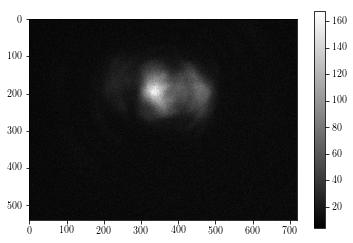



 Gen: 9 Range: 0.0006411254105087396 x waist
Time: 340.33321928977966, Fittest Parent: [-2.20813524e-07  6.08815276e-07  1.53800044e-05 -3.91476076e-05
 -3.72350396e-06], Fitness: 2459.5115356445312


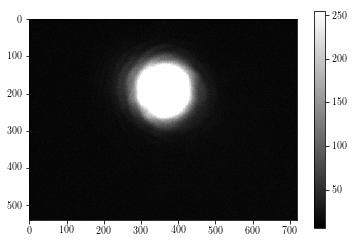



 Gen: 10 Range: 0.00027116303413339055 x waist
Time: 374.3813135623932, Fittest Parent: [ 3.44275744e-06  4.27596706e-06  3.33999121e-04 -1.14790917e-04
  3.72260697e-06], Fitness: 2382.77685546875


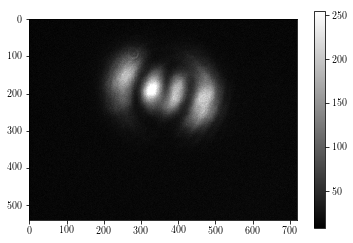



 Gen: 11 Range: 0.00011468799999999998 x waist
Time: 408.4337809085846, Fittest Parent: [ 2.99016178e-06  1.86553539e-05 -3.00548155e-05  1.25511266e-04
  3.72930496e-06], Fitness: 1594.0911254882812


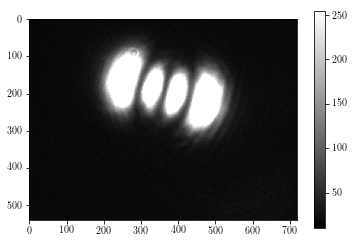



 Gen: 12 Range: 4.850711818458856e-05 x waist
Time: 442.4984304904938, Fittest Parent: [ 6.66940189e-06  2.06312007e-05  3.36391828e-04 -1.26496053e-04
 -2.64820201e-11], Fitness: 571.3143310546875


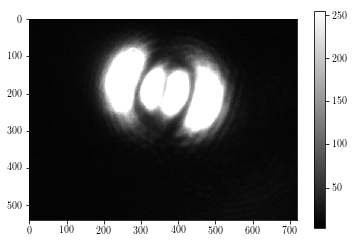



 Gen: 13 Range: 2.0516013136279667e-05 x waist
Time: 476.56581807136536, Fittest Parent: [ 1.27635154e-05 -4.53095170e-09  2.40353595e-07  1.26267485e-04
 -3.72880567e-06], Fitness: 598.9010009765625


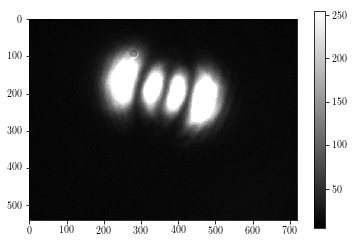



 Gen: 14 Range: 8.677217092268497e-06 x waist
Time: 510.616069316864, Fittest Parent: [-7.94195906e-08  1.88985840e-05 -4.11500153e-08  9.42456450e-06
  1.89394707e-11], Fitness: 839.0206298828125


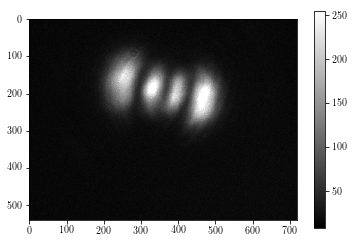



 Gen: 15 Range: 3.6700159999999996e-06 x waist
Time: 544.6727705001831, Fittest Parent: [ 1.27691453e-05  1.84751217e-05 -1.92092226e-05  2.62016588e-08
 -2.56047425e-11], Fitness: 1277.578125


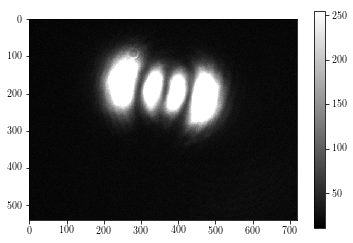



 Gen: 16 Range: 1.552227781906834e-06 x waist
Time: 578.6906363964081, Fittest Parent: [-6.39334536e-09 -1.84763915e-05  7.04741976e-07  1.27416851e-08
  3.90590293e-06], Fitness: 594.7069091796875


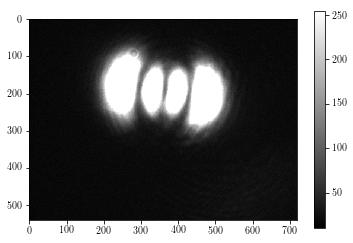



 Gen: 17 Range: 6.565124203609494e-07 x waist
Time: 612.8115792274475, Fittest Parent: [ 4.69785448e-10  2.00045624e-05  4.41592899e-08 -6.95547582e-09
  6.14884189e-11], Fitness: 816.3129272460938


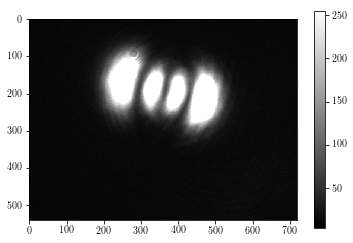



 Gen: 18 Range: 2.776709469525919e-07 x waist
Time: 646.8661441802979, Fittest Parent: [ 1.52218059e-09  2.00027180e-05 -7.13051150e-07 -3.93208526e-08
 -3.90590322e-06], Fitness: 816.0629272460938


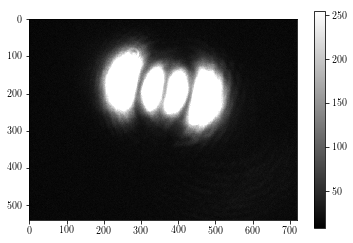



 Gen: 19 Range: 1.1744051199999998e-07 x waist
Time: 680.9353170394897, Fittest Parent: [-1.71477730e-09 -2.00046851e-05 -7.25838881e-07  3.87214404e-08
  3.90590255e-06], Fitness: 763.1470947265625


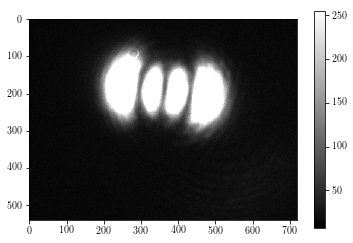



 Gen: 20 Range: 4.9671289021018684e-08 x waist
Time: 714.9774866104126, Fittest Parent: [ 1.27672545e-05  1.93900073e-09 -1.35302366e-08  3.70573819e-08
  6.09282915e-11], Fitness: 676.0012817382812


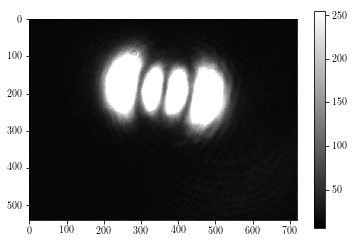



 Gen: 21 Range: 2.100839745155038e-08 x waist
Time: 749.0202910900116, Fittest Parent: [ 1.68675445e-09 -1.50401921e-11  4.31813607e-08 -3.78933963e-08
 -3.90591719e-06], Fitness: 540.15869140625


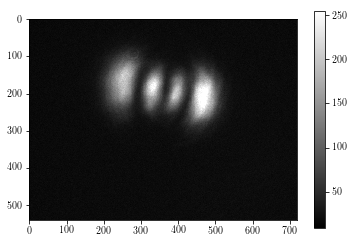



 Gen: 22 Range: 8.88547030248294e-09 x waist
Time: 783.088538646698, Fittest Parent: [-6.40919076e-12  2.10324900e-09 -7.30313302e-07  3.87017902e-08
 -7.21855200e-15], Fitness: 567.53125


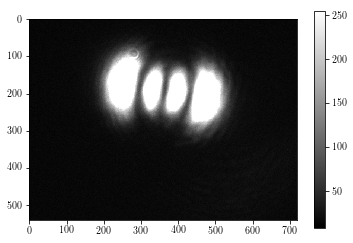



 Gen: 23 Range: 3.758096383999999e-09 x waist
Time: 817.1804068088531, Fittest Parent: [ 2.41790513e-12  5.14499593e-12  1.90281802e-09  1.87504757e-11
 -3.90591719e-06], Fitness: 615.31298828125


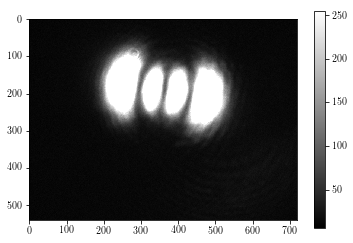



 Gen: 24 Range: 1.5894812486725978e-09 x waist
Time: 851.22047996521, Fittest Parent: [-1.46084414e-09  2.00049743e-05 -3.53139239e-11 -3.65495166e-08
  1.48157921e-15], Fitness: 664.92041015625


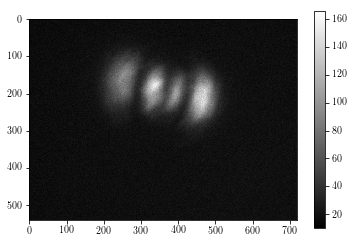

In [7]:
# Creating the initial population of deltas
new_pop_deltas = sample_d(Range, shape=pop_size)
print("\n\nRange:", Range, "x waist")

gen = 0
t0 = time.time()
for gen in range(25):
    # Shrink range
    Range *= shrink_factor
    print("\n\n Gen: {} Range: {} x waist".format(gen, Range))
    if gen == 0:
        current_beam_status, new_pop_deltas, fitness = calc_pop_fitness(current_beam_status, \
        new_pop_deltas, fitness, only_offsprings=False)
    else:
        current_beam_status, new_pop_deltas, fitness = calc_pop_fitness(current_beam_status, \
        new_pop_deltas, fitness, only_offsprings=True)
    # Selecting the best parents in the population for mating.
    parents, parents_fitness = select_mating_pool(new_pop_deltas, fitness, \
                                                  num_parents_mating, show_the_best=True, save_best=True)
    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, (pop_per_gen - num_parents_mating, num_params))
    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover, Range)
    # Creating the new population based on the parents and offspring.
    new_pop_deltas[0:num_parents_mating, :] = parents
    new_pop_deltas[num_parents_mating:, :] = offspring_mutation
    fitness[0:num_parents_mating] = parents_fitness
    fitness[num_parents_mating:] *= 0.

689.2456665039062


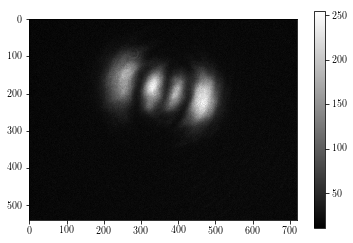

In [8]:
Img1 = Capture_image(20)
print(Img1.sum()/n_pixl**2)
plt.imshow(Img1[::-1], cmap=cm.binary_r)
plt.colorbar()

In [9]:
# Stop camera and DAC
camera.Close()
bus.stop()

## Make gif of the images

In [10]:
import imageio

files = os.listdir(ImagesFolder)
files.sort()
images = []
for filename in files:
    images.append(imageio.imread(ImagesFolder+'/'+filename))
imageio.mimsave(ImagesFolder + '/movie.gif', images, duration=0.5)